<a href="https://colab.research.google.com/github/iRocktys/iBankys/blob/main/previsaoTemporal_Arima_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibilotecas e importacoes

In [25]:
# !pip install pmdarima

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import yfinance as yf

# ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

# PROPHET
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [32]:
acoes = ['BTC-USD']
star_date = '2019-01-01'
end_date = '2024-03-09'

# Criar DataFrame com pandas
acoes_df = pd.DataFrame()

# Buscando dos os fechamentos de preço das ações na data especificada
for acao in acoes:
  dados = yf.download(acao, start=star_date, end=end_date)
  acoes_df[acao] = dados['Close']

# Renomear nome das ações
acoes_df = acoes_df.rename(columns={'BTC-USD' : 'BTC'})

# Caso houver valores nulos retira-los do DataFrame
# acoes_df.isnull().sum()
acoes_df.dropna(inplace=True)

# Salvar em arquivo CSV
acoes_df.to_csv('acoes.csv')

[*********************100%%**********************]  1 of 1 completed


# Modelo ARIMA, previsões de series temporais


In [33]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
dateset = pd.read_csv('acoes.csv', parse_dates=['Date'], index_col='Date', date_parser= dateparse, usecols= ['Date', 'BTC'])

In [34]:
time_series = dateset['BTC']

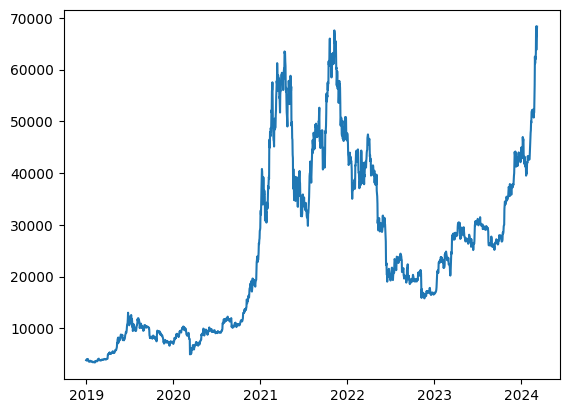

In [39]:
plt.plot(time_series);
# figura = px.line(title='Historico do preço das ações')
# figura.add_scatter(x = time_series.index, y = time_series)

In [41]:
time_series_datas = time_series['2019-01-01': '2024-03-09']
time_series_datas

Date
2019-01-01     3843.520020
2019-01-02     3943.409424
2019-01-03     3836.741211
2019-01-04     3857.717529
2019-01-05     3845.194580
                  ...     
2024-03-04    68330.414062
2024-03-05    63801.199219
2024-03-06    66106.804688
2024-03-07    66925.484375
2024-03-08    68300.093750
Name: BTC, Length: 1894, dtype: float64

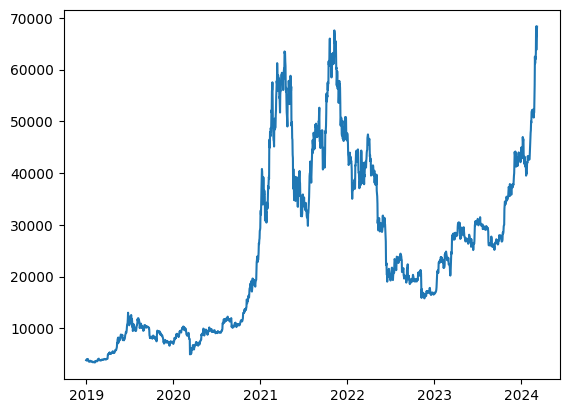

In [42]:
plt.plot(time_series_datas)

Decomposisão da série temporal

In [43]:
decomposicao = seasonal_decompose(time_series, period=len(time_series) // 2)

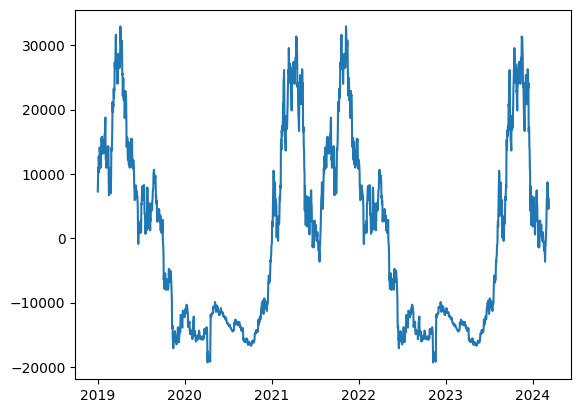

In [61]:
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
aleatorio = decomposicao.resid

plt.plot(sazonal);

Modelo ARIMA

In [45]:
modelo = auto_arima(time_series, suppress_warnings=True, error_action='ignore')

In [62]:
# Parâmetro P, Q D
modelo.order

(2, 1, 2)

In [63]:
previsoes = modelo.predict(n_periods=1800)

In [64]:
previsoes

2024-03-09    68199.760461
2024-03-10    68075.748728
2024-03-11    68069.215018
2024-03-12    68181.859165
2024-03-13    68280.744173
                  ...     
2029-02-06    68174.493650
2029-02-07    68174.493650
2029-02-08    68174.493650
2029-02-09    68174.493650
2029-02-10    68174.493650
Freq: D, Length: 1800, dtype: float64

In [66]:
treinamento = time_series[:1800]
treinamento.index.min(), treinamento.index.max()

teste = time_series[1800:]



In [67]:
modelo2 = auto_arima(treinamento, suppress_warnings=True, error_action='ignore')

In [68]:
teste.index

DatetimeIndex(['2023-12-06', '2023-12-07', '2023-12-08', '2023-12-09',
               '2023-12-10', '2023-12-11', '2023-12-12', '2023-12-13',
               '2023-12-14', '2023-12-15', '2023-12-16', '2023-12-17',
               '2023-12-18', '2023-12-19', '2023-12-20', '2023-12-21',
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31', '2024-01-01', '2024-01-02',
               '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06',
               '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-01-17', '2024-01-18',
               '2024-01-19', '2024-01-20', '2024-01-21', '2024-01-22',
               '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26',
               '2024-01-27', '2024-01-28', '2024-01-29', '2024-01-30',
      

In [72]:
previsoes = pd.DataFrame(modelo2.predict(n_periods=94))
previsoes.index = teste.index
previsoes.columns = ['previsoes']

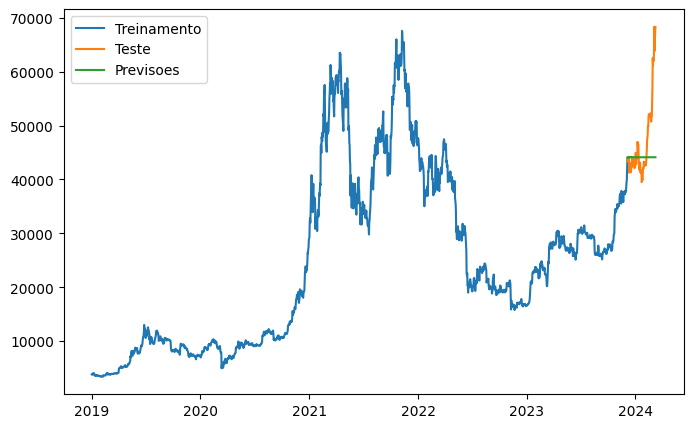

In [73]:
plt.figure(figsize=(8,5))
plt.plot(treinamento, label='Treinamento')
plt.plot(teste, label='Teste')
plt.plot(previsoes, label='Previsoes')
plt.legend();

In [74]:
# Avaliar perda em reais nas previsoes
sum(abs(teste-previsoes['previsoes']) / len(teste))

4682.835229805315

In [75]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(teste, previsoes)

4682.835229805315

# Modelo PROPHET


In [93]:
dateset = pd.read_csv('acoes.csv', parse_dates=['Date'], date_parser= dateparse, usecols= ['Date','BTC'])
# Possui padrao na nomenclatura das colunas
dateset = dateset.rename(columns = {'Date':'ds', 'BTC':'y'})
dateset

,ds,y
0,2019-01-01,3843.520020
1,2019-01-02,3943.409424
2,2019-01-03,3836.741211
3,2019-01-04,3857.717529
4,2019-01-05,3845.194580
...,...,...
1889,2024-03-04,68330.414062
1890,2024-03-05,63801.199219
1891,2024-03-06,66106.804688
1892,2024-03-07,66925.484375


In [94]:
modelo = Prophet()
modelo.fit(dateset)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkt_2k64s/7xfaa5ky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkt_2k64s/dydygbyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21883', 'data', 'file=/tmp/tmpkt_2k64s/7xfaa5ky.json', 'init=/tmp/tmpkt_2k64s/dydygbyr.json', 'output', 'file=/tmp/tmpkt_2k64s/prophet_modelc4wh9i1o/prophet_model-20240309162536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:25:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:25:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [95]:
futuro = modelo.make_future_dataframe(periods=90)
previsoes = modelo.predict(futuro)

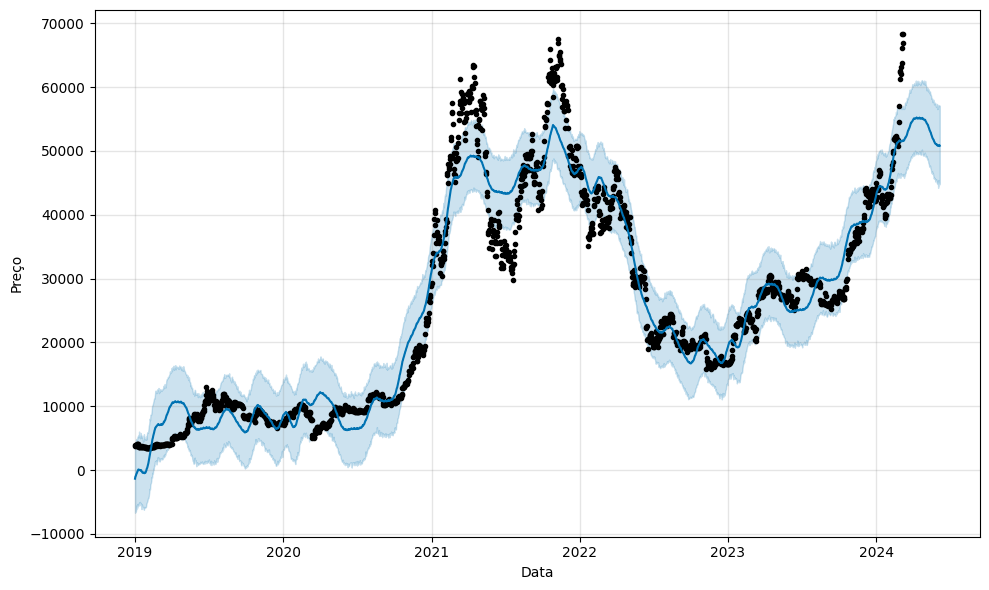

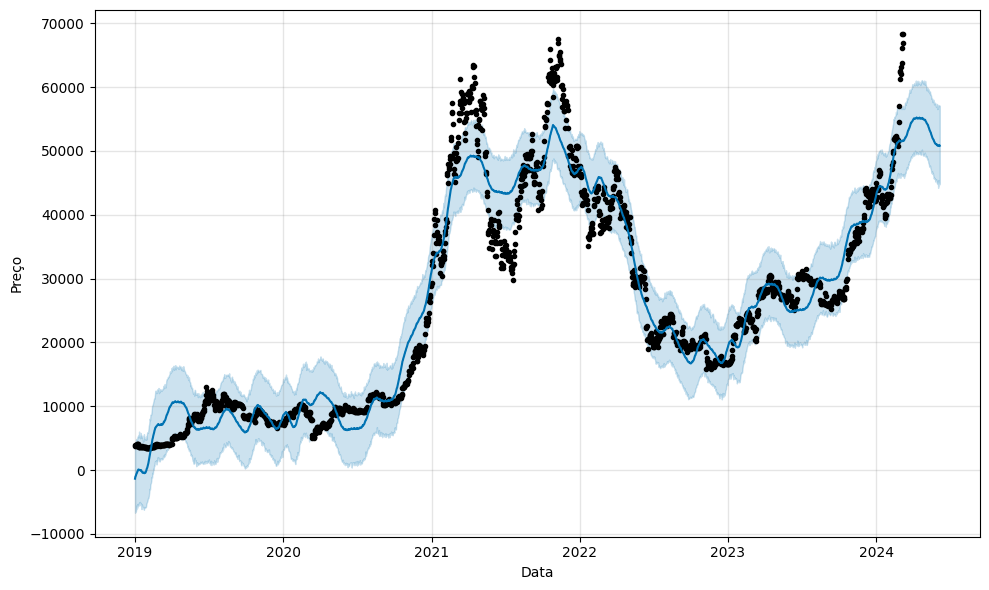

In [96]:
modelo.plot(previsoes, xlabel = 'Data', ylabel = 'Preço')

In [97]:
plot_plotly(modelo, previsoes)

In [104]:
pred = modelo.make_future_dataframe(periods=0)
previsoes = modelo.predict(pred)
previsoes = previsoes['yhat'].tail(94)

In [105]:
mean_absolute_error(teste, previsoes)

3303.226486322836